# Correlation analysis (Cross Encoder, TFC1)
### This notebook contains analysis of correlation between different properties of the data and the strength of the patching effect

In [1]:
%load_ext autoreload
%autoreload 2

In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
from transformers import AutoTokenizer
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import pearsonr, spearmanr, kendalltau
from pingouin import partial_corr

from catboost import CatBoostRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

from collections import Counter
import math

from utils.utils import compute_perturbation_featues

sns.set(style="whitegrid")


MODEL_NAME = 'crystina-z/monoELECTRA_LCE_nneg31'
FORMATTED_MODEL_NAME = MODEL_NAME.replace('/', '-')
MODEL_TYPE = 'cross'
PERTURBATION = 'TFC1'
K = 4000
BATCH_SIZE = 20

tokenizer = AutoTokenizer.from_pretrained(MODEL_NAME)

### Load all necessary data

In [5]:
# Load query document pairs on which patching was performed
query_doc_pairs = pd.read_csv(f'./data/diagnostic_dataset/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_topk_{K}.tsv', sep='\t')

# Load various textual features of queries and documents
doc_features = pd.read_csv(f'./data/diagnostic_dataset/documents_with_features.tsv', sep='\t').drop_duplicates(subset=['docno'])
query_features = pd.read_csv(f'./data/diagnostic_dataset/queries_with_features.tsv', sep='\t').drop_duplicates(subset=['query_id'])

# Merge features with queries and documents
query_doc_pairs = query_doc_pairs.merge(doc_features, on=['docno'], suffixes=('', '_doc'))
query_doc_pairs = query_doc_pairs.merge(query_features, left_on=['qid'], right_on=['query_id'], suffixes=('', '_query'))

# Load patching results
patching_results_path = f'./data/patching_results/{FORMATTED_MODEL_NAME}_{MODEL_TYPE}_{PERTURBATION}_{K}_batch_size_{BATCH_SIZE}_patch_head.npy'
patching_results = np.load(patching_results_path)
original_scores = np.load(patching_results_path.replace('_patch_head.npy', '_original_scores.npy'))
perturbed_scores = np.load(patching_results_path.replace('_patch_head.npy', '_perturbed_scores.npy'))

### Compute perturbation features

TFC1 perturbation involves only adding one term to the document
Thus, all pertirbation features are the features of that injected term

In [6]:
# Extract injected term from perturbed text
query_doc_pairs['injected_term'] = query_doc_pairs['perturbed_text'].apply(lambda x: x.rsplit(' ', 1)[1])

# Compute features of the injected term
query_doc_pairs = compute_perturbation_featues(query_doc_pairs, tokenizer)

Jan 15, 2026 1:37:33 PM org.apache.lucene.store.MemorySegmentIndexInputProvider <init>
INFO: Using MemorySegmentIndexInput with Java 21; to disable start with -Dorg.apache.lucene.store.MMapDirectory.enableMemorySegments=false


### Compute target metrics

Here we will merge the features of the data and the patching effects.
Since we are interested in the pronouncement of the patching effect, we compute the mean and the standatd deviation of the patching effect across all attention heads.

In [7]:
def add_target_metrics(data, patching_results, original_scores, perturbed_scores):
    # Score of an original document
    data['original_score'] = original_scores
    # Score of a perturbed document
    data['perturbed_score'] = perturbed_scores
    
    # Score difference
    data['score_delta'] = perturbed_scores - original_scores
     
    # Patching effect: difference between the patched score and the original score
    # Original normalisation
    patching_results_normalised = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                np.abs((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis])))
    # Our proposed normalisation
    patching_results_normalised_robust = ((patching_results - original_scores[:, np.newaxis, np.newaxis]) / 
                                        np.sqrt(1 + np.square((perturbed_scores[:, np.newaxis, np.newaxis] - original_scores[:, np.newaxis, np.newaxis]))))
    
    data['patching_effect_std'] = np.std(patching_results - original_scores[:, np.newaxis, np.newaxis], axis=(-1,-2))
    data['patching_effect_absolute_mean'] = np.mean(np.abs(patching_results - original_scores[:, np.newaxis, np.newaxis]), axis=(-1,-2))
    data['patching_effect_normalised_std'] = np.std(patching_results_normalised, axis=(-1,-2))
    data['patching_effect_normalised_absolute_mean'] = np.mean(np.abs(patching_results_normalised), axis=(-1,-2))
    data['patching_effect_normalised_robust_std'] = np.std(patching_results_normalised_robust, axis=(-1,-2))
    data['patching_effect_normalised_robust_absolute_mean'] = np.mean(np.abs(patching_results_normalised_robust), axis=(-1,-2))

    return data

query_doc_pairs = add_target_metrics(query_doc_pairs, patching_results, original_scores, perturbed_scores)

### Plot correlation between score difference and patching effect

This code reproduces Figure 2 in the paper (its part related to cross encoder)

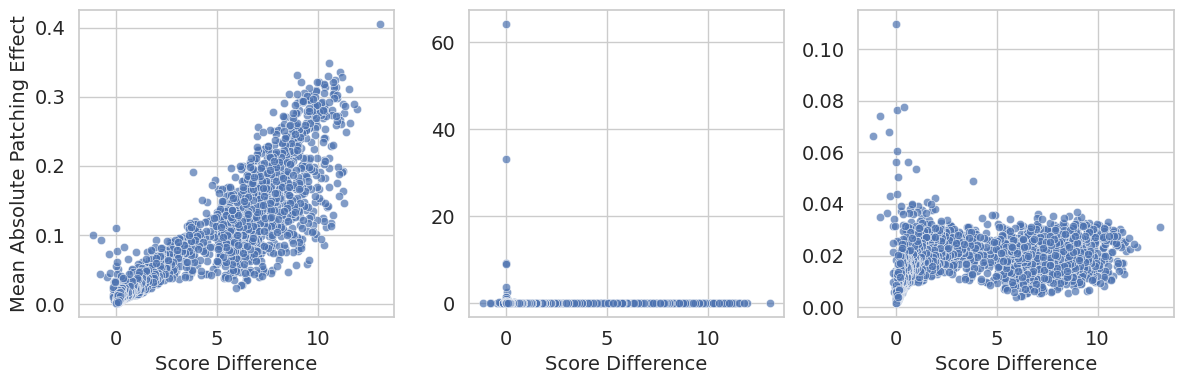

In [8]:
metric_list = [('score_delta', 'patching_effect_absolute_mean'),
               ('score_delta', 'patching_effect_normalised_absolute_mean'),
               ('score_delta', 'patching_effect_normalised_robust_absolute_mean'),
]

fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for idx, ax in enumerate(axes):
    sns.scatterplot(
        data=query_doc_pairs,
        x=metric_list[idx][0],
        y=metric_list[idx][1],
        ax=ax,
        alpha=0.7
    )
    ax.set_xlabel('Score Difference', fontsize=14)
    if idx == 0:
        ax.set_ylabel('Mean Absolute Patching Effect', fontsize=14)
    else:
        ax.set_ylabel('')
    # ax.set_ylabel('Mean Absolute Patching Effect', fontsize=14)
    ax.grid(True)
    ax.tick_params(axis='x', labelsize=14)
    ax.tick_params(axis='y', labelsize=14)
    
plt.tight_layout()